In [ ]:
!pip install torch transformers unsloth datasets scikit-learn matplotlib seaborn
import torch
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


In [ ]:
import os
cache_dir_path = "/content/hf-cache"
os.environ["HF_HOME"] = "/content/hf-cache"
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_from_disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
from unsloth import FastLanguageModel
qwen_model, qwen_tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/major_project_models/my_model_19_03",
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
        device_map="auto"
    )
FastLanguageModel.for_inference(qwen_model)

In [ ]:
db_model_ckpt = "/content/drive/MyDrive/major_project_models/distilbert-checkpoint-1280"
db_tokenizer = AutoTokenizer.from_pretrained(db_model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
db_model = (AutoModelForSequenceClassification
         .from_pretrained(db_model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
cb_model_ckpt = "/content/drive/MyDrive/major_project_models/codebert-checkpoint-1280"
cb_tokenizer = AutoTokenizer.from_pretrained(cb_model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
cb_model = (AutoModelForSequenceClassification
         .from_pretrained(cb_model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
from datasets import load_from_disk
test_dataset_path = "/content/drive/MyDrive/major_project_models/dataset_filtered_unsloth/Qwen2-1.5b-bnb-4bit_1024/test"
dataset = load_from_disk(test_dataset_path)

In [ ]:
dataset

In [ ]:
def create_classification_input(row):

    code_changes = f"""
    Existing code:\n\n

    ```\n
    {row['oldf']}
    ```

    Proposed change:\n\n

    ```\n
    {row['patch']}
    ```
    """

    return {"code": code_changes, "y": row['y']}

In [ ]:
from tqdm import tqdm
import csv
import torch

with open('ensemble_results_19March.csv', 'w', newline='') as csvfile:
    fieldnames = ['idx', 'id', 'ground_truth', 'model_prediction_qwen', 'full_op_qwen', "cb_prediction", "db_prediction", "msg", "lang", "seq_len"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for entry in tqdm(dataset):
        old_c = entry["oldf"]
        new_c = entry["patch"]
        gt    = entry["y"]
        messages = [
            {"role": "user", "content": f"You are given a diff from a pull request, containing some old code, as well as the code written by a developer to replace it.\n\n### Old Code:\n{old_c}\n\n### Proposed Code:\n{new_c}\n\nDetermine if this pull request is likely good to merge or requires the review of another developer.\nOutput only whether it requires a review or not by saying YES or NO. Do NOT output anything else."},
        ]
        inputs = qwen_tokenizer.apply_chat_template(
            messages,
            tokenize = True,
            add_generation_prompt = True, # Must add for generation
            return_tensors = "pt",
        ).to("cuda")
        with torch.no_grad():
            outputs = qwen_model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                                     temperature = 1.5, min_p = 0.1)
            final_output = qwen_tokenizer.batch_decode(outputs)[0]
            assistant_start = final_output.find('<|im_start|>assistant\n')
            if assistant_start == -1:
                extracted_output = ""
            else:
                content_start = assistant_start + len('<|im_start|>assistant\n')
                content_end = final_output.find('<|im_end|>', content_start)
                if content_end == -1:
                    extracted_output = final_output[content_start:]
                else:
                    extracted_output = final_output[content_start:content_end]
            if "YES" in extracted_output:
                extracted_output = "1"
            elif "NO" in extracted_output:
                extracted_output = "0"

            #print(extracted_output)

            updated_entry = create_classification_input(entry)
            with torch.no_grad():
                cb_tk = cb_tokenizer(updated_entry['code'], return_tensors='pt', truncation=True, padding=True).to('cuda')
                cb_outputs = cb_model(**cb_tk)
                cb_logits = cb_outputs.logits
                cb_pred = torch.argmax(cb_logits, dim=1).item()
                #print(cb_pred)

            with torch.no_grad():
                db_tk = db_tokenizer(updated_entry['code'], return_tensors='pt', truncation=True, padding=True).to('cuda')
                db_outputs = db_model(**db_tk)
                db_logits = db_outputs.logits
                db_pred = torch.argmax(db_logits, dim=1).item()
                #print(db_pred)

            writer.writerow({
            'idx': entry["idx"],  # Truncate for readability
            'id': entry["id"],  # Truncate for readability
            'ground_truth': gt,
            'model_prediction_qwen': extracted_output,
            "cb_prediction": str(cb_pred),
            "db_prediction": str(db_pred),
            'full_op_qwen': final_output,
            'msg': entry['msg'],
            'lang': entry['lang'],
            'seq_len': entry["seq_len"]
        })


In [ ]:
import pandas as pd
df = pd.read_csv('ensemble_results_19March.csv')
cols = ['model_prediction_qwen', 'cb_prediction', 'db_prediction']
for col in cols:
    df[col] = df[col].astype(int)
df['majority'] = df[cols].apply(
    lambda row: '1' if row.sum() >= 2 else '0',
    axis=1
)

# Save the updated CSV
df.to_csv('ensemble_results_19March_v2.csv', index=False)


Confusion Matrix:
[[ 213  665]
 [ 319 4826]]
Accuracy: 0.8366
Precision: 0.8789
Recall: 0.9380
F1 Score: 0.9075


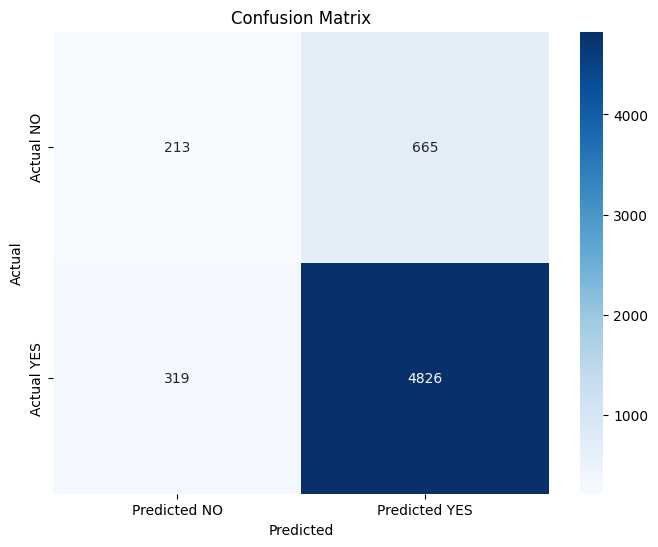


Using sklearn metrics:
Confusion Matrix:
[[ 213  665]
 [ 319 4826]]
Accuracy: 0.8366
Precision: 0.8789
Recall: 0.9380
F1 Score: 0.9075


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize counters
tp = 0  # True Positive: predicted YES when ground truth is 1
tn = 0  # True Negative: predicted NO when ground truth is 0
fp = 0  # False Positive: predicted YES when ground truth is 0
fn = 0  # False Negative: predicted NO when ground truth is 1
total = 0

with open('ensemble_results_19March_v2.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    y_true = []
    y_pred = []

    for row in reader:
        total += 1
        gt = row["ground_truth"]
        prediction = row["majority"]

        # Convert to binary format for metrics calculation
        y_true.append(int(gt))
        y_pred.append(int(prediction))

        # Count each case
        if prediction == "1" and gt == "1":
            tp += 1
        elif prediction == "0" and gt == "0":
            tn += 1
        elif prediction == "1" and gt == "0":
            fp += 1
        elif prediction == "0" and gt == "1":
            fn += 1

# Create confusion matrix manually
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Calculate metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NO', 'Predicted YES'],
            yticklabels=['Actual NO', 'Actual YES'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Alternative: Use sklearn's built-in functions
print("\nUsing sklearn metrics:")
print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


In [ ]:
##Plot Distil BERT SOLO RESULTS

Confusion Matrix:
[[ 264  614]
 [ 419 4726]]
Accuracy: 0.8285
Precision: 0.8850
Recall: 0.9186
F1 Score: 0.9015


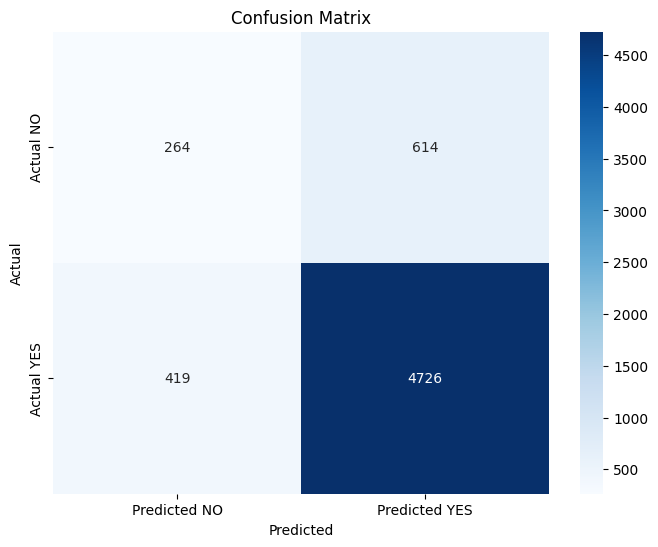


Using sklearn metrics:
Confusion Matrix:
[[ 264  614]
 [ 419 4726]]
Accuracy: 0.8285
Precision: 0.8850
Recall: 0.9186
F1 Score: 0.9015


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize counters
tp = 0  # True Positive: predicted YES when ground truth is 1
tn = 0  # True Negative: predicted NO when ground truth is 0
fp = 0  # False Positive: predicted YES when ground truth is 0
fn = 0  # False Negative: predicted NO when ground truth is 1
total = 0

with open('/content/drive/MyDrive/arpit_project/qwen_original/Qwen_14B/ensemble_results_19March_v2.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    y_true = []
    y_pred = []

    for row in reader:
        total += 1
        gt = row["ground_truth"]
        prediction = row["db_prediction"]

        # Convert to binary format for metrics calculation
        y_true.append(int(gt))
        y_pred.append(int(prediction))

        # Count each case
        if prediction == "1" and gt == "1":
            tp += 1
        elif prediction == "0" and gt == "0":
            tn += 1
        elif prediction == "1" and gt == "0":
            fp += 1
        elif prediction == "0" and gt == "1":
            fn += 1

# Create confusion matrix manually
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Calculate metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NO', 'Predicted YES'],
            yticklabels=['Actual NO', 'Actual YES'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Alternative: Use sklearn's built-in functions
print("\nUsing sklearn metrics:")
print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


In [ ]:
##CB Individual Result

Confusion Matrix:
[[ 232  646]
 [ 345 4800]]
Accuracy: 0.8355
Precision: 0.8814
Recall: 0.9329
F1 Score: 0.9064


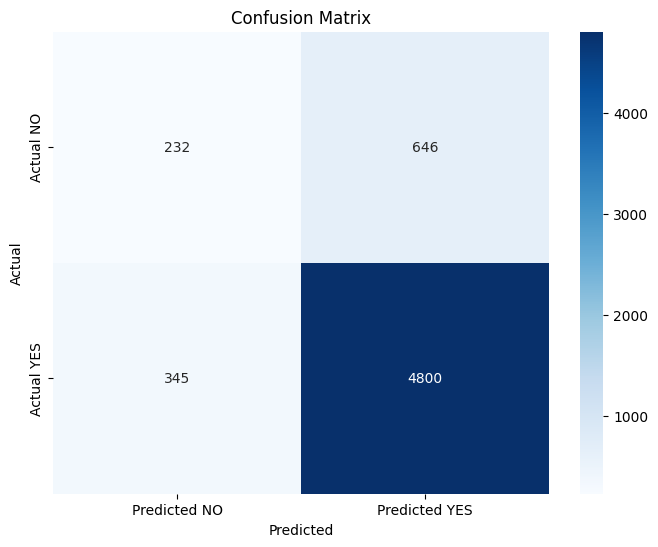


Using sklearn metrics:
Confusion Matrix:
[[ 232  646]
 [ 345 4800]]
Accuracy: 0.8355
Precision: 0.8814
Recall: 0.9329
F1 Score: 0.9064


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize counters
tp = 0  # True Positive: predicted YES when ground truth is 1
tn = 0  # True Negative: predicted NO when ground truth is 0
fp = 0  # False Positive: predicted YES when ground truth is 0
fn = 0  # False Negative: predicted NO when ground truth is 1
total = 0

with open('/content/drive/MyDrive/arpit_project/qwen_original/Qwen_14B/ensemble_results_19March_v2.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    y_true = []
    y_pred = []

    for row in reader:
        total += 1
        gt = row["ground_truth"]
        prediction = row["cb_prediction"]

        # Convert to binary format for metrics calculation
        y_true.append(int(gt))
        y_pred.append(int(prediction))

        # Count each case
        if prediction == "1" and gt == "1":
            tp += 1
        elif prediction == "0" and gt == "0":
            tn += 1
        elif prediction == "1" and gt == "0":
            fp += 1
        elif prediction == "0" and gt == "1":
            fn += 1

# Create confusion matrix manually
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Calculate metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NO', 'Predicted YES'],
            yticklabels=['Actual NO', 'Actual YES'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Alternative: Use sklearn's built-in functions
print("\nUsing sklearn metrics:")
print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize counters
tp = 0  # True Positive: predicted YES when ground truth is 1
tn = 0  # True Negative: predicted NO when ground truth is 0
fp = 0  # False Positive: predicted YES when ground truth is 0
fn = 0  # False Negative: predicted NO when ground truth is 1
total = 0

with open('ensemble_results_19March_v2.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    y_true = []
    y_pred = []

    for row in reader:
        total += 1
        gt = row["ground_truth"]
        prediction = row["majority"]

        # Convert to binary format for metrics calculation
        y_true.append(int(gt))
        y_pred.append(int(prediction))

        # Count each case
        if prediction == "1" and gt == "1":
            tp += 1
        elif prediction == "0" and gt == "0":
            tn += 1
        elif prediction == "1" and gt == "0":
            fp += 1
        elif prediction == "0" and gt == "1":
            fn += 1

# Create confusion matrix manually
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Calculate metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NO', 'Predicted YES'],
            yticklabels=['Actual NO', 'Actual YES'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Alternative: Use sklearn's built-in functions
print("\nUsing sklearn metrics:")
print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


In [ ]:
##QWEN Individual Result

Confusion Matrix:
[[ 332  546]
 [1102 4043]]
Accuracy: 0.7264
Precision: 0.8810
Recall: 0.7858
F1 Score: 0.8307


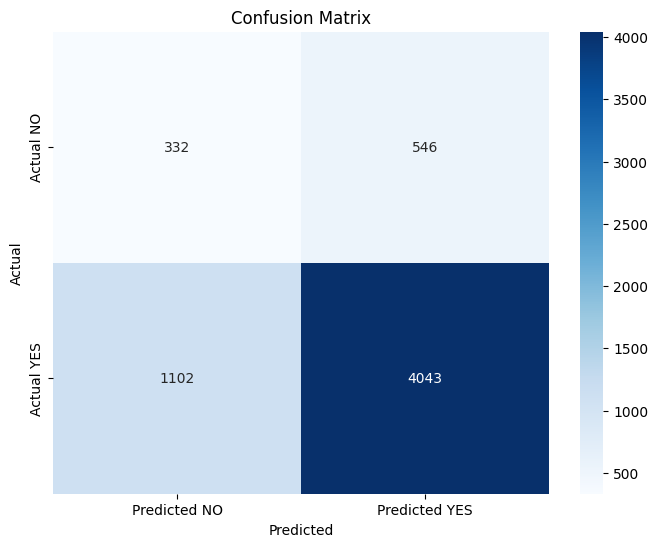


Using sklearn metrics:
Confusion Matrix:
[[ 332  546]
 [1102 4043]]
Accuracy: 0.7264
Precision: 0.8810
Recall: 0.7858
F1 Score: 0.8307


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize counters
tp = 0  # True Positive: predicted YES when ground truth is 1
tn = 0  # True Negative: predicted NO when ground truth is 0
fp = 0  # False Positive: predicted YES when ground truth is 0
fn = 0  # False Negative: predicted NO when ground truth is 1
total = 0

with open('ensemble_results_19March_v2.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    y_true = []
    y_pred = []

    for row in reader:
        total += 1
        gt = row["ground_truth"]
        prediction = row["model_prediction_qwen"]

        # Convert to binary format for metrics calculation
        y_true.append(int(gt))
        y_pred.append(int(prediction))

        # Count each case
        if prediction == "1" and gt == "1":
            tp += 1
        elif prediction == "0" and gt == "0":
            tn += 1
        elif prediction == "1" and gt == "0":
            fp += 1
        elif prediction == "0" and gt == "1":
            fn += 1

# Create confusion matrix manually
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Calculate metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NO', 'Predicted YES'],
            yticklabels=['Actual NO', 'Actual YES'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Alternative: Use sklearn's built-in functions
print("\nUsing sklearn metrics:")
print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
